# COVID 19 Doomsday
### Predicting the date on which continental sub-regions will experience the most deaths due to COVID 19 in a single day based on a logistic growth model.

In [1]:
# libraries

from pyspark.sql.functions import desc, asc
from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

import numpy as np
from math import log10, ceil
import matplotlib.pyplot as plt
import scipy.optimize as optim
import datetime as dt

### Raw death count data
Data source: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

In [2]:
deaths_path = "time_series_covid19_deaths_global.csv"
deaths_raw = spark.read.csv(deaths_path, sep=',', inferSchema=True, header=True).cache()

# display
deaths_raw.limit(3).toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,None,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15,15,18,18,21,23,25,30,30,30
1,None,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,23,23,23,24,25,26,26,26
2,None,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,235,256,275,293,313,326,336,348,364,367


### Deaths by country

In [3]:
# drop irrelevant columns and group deaths by country
deaths = deaths_raw \
            .drop('Province/State', 'Lat', 'Long') \
            .withColumnRenamed('Country/Region', 'Country') \
            .groupby('Country') \
            .sum()

deaths2 = deaths \
            .toDF(*deaths.columns) \
            .cache() 

# display
deaths2.limit(3).toPandas()

,Country,sum(1/22/20),sum(1/23/20),sum(1/24/20),sum(1/25/20),sum(1/26/20),sum(1/27/20),sum(1/28/20),sum(1/29/20),sum(1/30/20),...,sum(4/9/20),sum(4/10/20),sum(4/11/20),sum(4/12/20),sum(4/13/20),sum(4/14/20),sum(4/15/20),sum(4/16/20),sum(4/17/20),sum(4/18/20)
0,Chad,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Paraguay,0,0,0,0,0,0,0,0,0,...,5,6,6,6,6,7,8,8,8,8
2,Russia,0,0,0,0,0,0,0,0,0,...,76,94,106,130,148,170,198,232,273,313


### Raw geography data
Data source: https://www.kaggle.com/statchaitya/country-to-continent/data

In [4]:
regions_path = "countryContinent.csv"
regions_raw = spark.read.csv(regions_path, sep=',', inferSchema=True, header=True).cache()

# display
regions_raw.limit(3).toPandas()

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142,34
1,�land Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150,154
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150,39


### Join deaths by country data with geography data

In [5]:
deaths2.createOrReplaceTempView("deaths2")
regions_raw.createOrReplaceTempView("regions_raw")

regional_deaths = spark.sql('select * \
                             from deaths2 as d \
                             left join (select country, continent, sub_region from regions_raw) as r \
                                 on d.Country = r.country')

# display
regional_deaths.limit(3).toPandas()

,Country,sum(1/22/20),sum(1/23/20),sum(1/24/20),sum(1/25/20),sum(1/26/20),sum(1/27/20),sum(1/28/20),sum(1/29/20),sum(1/30/20),...,sum(4/12/20),sum(4/13/20),sum(4/14/20),sum(4/15/20),sum(4/16/20),sum(4/17/20),sum(4/18/20),country,continent,sub_region
0,Chad,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Chad,Africa,Middle Africa
1,Paraguay,0,0,0,0,0,0,0,0,0,...,6,6,7,8,8,8,8,Paraguay,Americas,South America
2,Russia,0,0,0,0,0,0,0,0,0,...,130,148,170,198,232,273,313,None,None,None


### Find countries not included in the geography dataset
we manually insert this data in the next step

In [6]:
null_regions = regional_deaths.filter('sub_region is null')

# display
null_regions.select('d.Country').show(100)

+-------------------+
|            Country|
+-------------------+
|             Russia|
|              Burma|
|             Kosovo|
|         MS Zaandam|
|            Bolivia|
|            Czechia|
|   Congo (Kinshasa)|
|               Iran|
|                 US|
|               Laos|
|          Venezuela|
|            Taiwan*|
|      Cote d'Ivoire|
|              Syria|
|Congo (Brazzaville)|
|           Eswatini|
|             Brunei|
|    North Macedonia|
|       Korea, South|
| West Bank and Gaza|
|           Tanzania|
|            Moldova|
|     United Kingdom|
|            Vietnam|
|   Diamond Princess|
+-------------------+



### Manually enter missing geography data

In [8]:
manual_entries = {
        "Bolivia": ('Americas', 'South America'),
        "Brunei": ('Asia', 'South-Eastern Asia'),
        "Burma": ('Asia', 'South-Eastern Asia'),
        "Congo (Brazzaville)": ('Africa', 'Middle Africa'),
        "Congo (Kinshasa)": ('Africa', 'Middle Africa'),
        "Cote d'Ivoire": ('Africa', 'Western Africa'),
        "Czechia": ('Europe', 'Eastern Europe'),
        "Diamond Princess": ("Cruise Ship", "Cruise Ship"),
        "Eswatini": ('Africa', 'Southern Africa'),
        "Iran": ('Asia', 'Western Asia'),
        "Korea, South": ('Asia', 'South-Eastern Asia'),
        "Kosovo": ('Europe', 'Southern Europe'),
        "Laos": ('Asia', 'South-Eastern Asia'),
        "MS Zaandam": ("Cruise Ship", "Cruise Ship"),
        "Moldova": ('Europe', 'Eastern Europe'),
        "North Macedonia": ('Europe', 'Southern Europe'),
        "Russia": ('Europe', 'Eastern Europe'),
        "Syria": ('Asia', 'Western Asia'),
        "Taiwan*": ('Asia', 'Eastern Asia'),
        "Tanzania": ('Africa', 'Eastern Africa'),
        "US": ('Americas', 'Northern America'),
        "United Kingdom": ('Europe', 'Northern Europe'),
        "Venezuela": ('Americas', 'South America'),
        "Vietnam": ('Asia', 'South-Eastern Asia'),
        "West Bank and Gaza": ('Asia', 'Western Asia')
    }

# enters missing data in row
def enter_data(row):
    country = row[0]
    if country in manual_entries.keys():
        continent = manual_entries[country][0]
        sub_region = manual_entries[country][1]
        return tuple(list([continent] + [sub_region] + row[:-3]))
    else:
        return tuple(list(row[-2:]) + list(row[:-3]))

# drop cruise ship deaths and map enter_data
regional_deaths2 = regional_deaths \
                    .filter('continent <> "Cruise Ship"') \
                    .rdd \
                    .map(enter_data) \
                    .toDF() \
                    .cache()

# display
regional_deaths2.limit(3).toPandas()

,_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,...,_82,_83,_84,_85,_86,_87,_88,_89,_90,_91
0,Africa,Middle Africa,Chad,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Americas,South America,Paraguay,0,0,0,0,0,0,0,...,5,6,6,6,6,7,8,8,8,8
2,Asia,Western Asia,Yemen,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Deaths by continental sub-region

In [9]:
# drop country column and group deaths by sub-region
deathsByRegion = regional_deaths2 \
                    .drop('_3') \
                    .orderBy('_1', '_2') \
                    .groupBy('_1', '_2') \
                    .sum() \
                    .cache()

# display
deathsByRegion.limit(3).toPandas()

,_1,_2,sum(_4),sum(_5),sum(_6),sum(_7),sum(_8),sum(_9),sum(_10),sum(_11),...,sum(_82),sum(_83),sum(_84),sum(_85),sum(_86),sum(_87),sum(_88),sum(_89),sum(_90),sum(_91)
0,Africa,Eastern Africa,0,0,0,0,0,0,0,0,...,22,27,29,30,33,33,37,38,39,41
1,Africa,Middle Africa,0,0,0,0,0,0,0,0,...,13,15,15,15,15,17,20,25,25,25
2,Africa,Northern Africa,0,0,0,0,0,0,0,0,...,478,526,563,604,642,670,687,717,748,776


### Logistic growth model for daily deaths due to COVID-19
reference: https://towardsdatascience.com/modeling-logistic-growth-1367dc971de2

In [10]:
# produces logistic growth model for COVID-19 deaths
def model(row):
    continent = row[0]
    region = row[1]
    
    y = np.array(row[2:]) # deaths
    x = np.array(range(1, len(y) + 1)) # days
    
    def logistic_func(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))

    #p0 = np.random.exponential(size=3)
    p0 = np.array([1.68381448, 0.3322786 , 2.25564035]) # these were randomly generated

    bounds = (0, [1000000., 3., 1000000000.])

    (a,b,c),cov = optim.curve_fit(logistic_func, x, y, bounds=bounds, p0=p0, maxfev=1000000)

    return region, float(a), float(b), float(c), list(map(int, list(x))), list(map(int, list(y)))

### Model inputs by continental sub-region

In [11]:
# map model to deaths by region data
deathsByRegionModel = deathsByRegion \
                        .rdd \
                        .map(model) \
                        .toDF() \
                        .withColumnRenamed('_1', 'Sub-Region') \
                        .withColumnRenamed('_2', 'a') \
                        .withColumnRenamed('_3', 'b') \
                        .withColumnRenamed('_4', 'c') \
                        .withColumnRenamed('_5', 'day') \
                        .withColumnRenamed('_6', 'deaths') \
                        .cache()

# display
deathsByRegionModel.toPandas()

,Sub-Region,a,b,c,day,deaths
0,Eastern Africa,1000000.000000,0.172465,51.710980,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Middle Africa,39794.171291,0.131590,32.203070,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Northern Africa,1000000.000000,0.174977,940.440195,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Southern Africa,1000000.000000,0.147885,173.872088,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Western Africa,153962.941392,0.150935,138.319416,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Caribbean,1000000.000000,0.172970,346.950533,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Central America,1000000.000000,0.152442,1812.781145,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Northern America,999999.999994,0.145830,5307.858245,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,South America,1000000.000000,0.160130,6185.981396,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Central Asia,1000000.000000,0.170437,36.444611,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Plot of model for each continental sub-region
Now that the data has been reduced to the model data found in deathsByRegionModel, we will plot and analyze it.

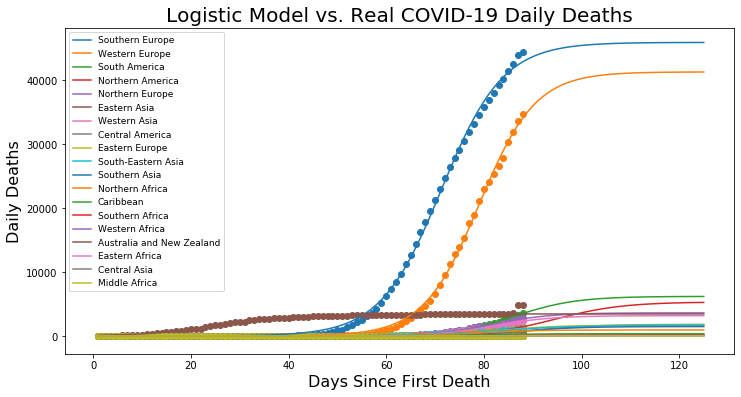

In [18]:
model_data = deathsByRegionModel.sort(desc('c')).collect()

def logistic_func(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))
    
plt.figure(figsize=(12,6))
for row in model_data:
    # row data
    region = row[0]
    a = row[1]
    b = row[2]
    c = row[3]    
    x = np.array(row[4])
    x = np.append(x, range(max(x)+1, 126)) # look at entire year following first case
    y = np.array(row[5])
    y = np.append(y, [np.nan] * (len(x) - len(y)))
    
    # graphs
    if max(y) > 0:
        plt.scatter(x, y)
        plt.plot(x, logistic_func(x, a, b, c), label=region)
        plt.title('Logistic Model vs. Real COVID-19 Daily Deaths', fontsize=20)
        plt.xlabel('Days Since First Death', fontsize=16)
        plt.ylabel('Daily Deaths', fontsize=16)
plt.legend(fontsize=9)

### Find maximum daily death as predicted by the model

In [19]:
# produces the day on which the maximum daily number of deaths will occur for a region
# based on logistic_func
def doomsday(row):
    def logistic_func(t, a, b, c):
        return c / (1 + a * np.exp(-b*t))
    
    # row data
    region = row[0]
    a = row[1]
    b = row[2]
    c = row[3]    
    x = np.array(row[4])
    y = np.array(row[5])
    
    # peak_deaths assumes the limit on the maximum daily number of predicted deaths occurs 
    # by the 29,200th day (i.e., a lifetime = 365 days * 80 years) after the first case.
    # The plot above show that this is a reasonable assumption based on current data.
    peak_deaths = ceil(logistic_func(29200, a, b, c))
    doomsday = 0
    while ceil(logistic_func(doomsday, a, b, c)) != peak_deaths:
        doomsday += 1
        
    return region, doomsday, peak_deaths  

doomsday = deathsByRegionModel \
            .rdd \
            .map(doomsday) \
            .map(lambda x: (x[0], x[1], dt.datetime.strptime('01/22/20', "%m/%d/%y") + dt.timedelta(days=x[1]), x[2])) \
            .toDF() \
            .withColumnRenamed('_1', 'Sub-Region') \
            .withColumnRenamed('_2', 'Day #') \
            .withColumnRenamed('_3', 'Date') \
            .withColumnRenamed('_4', 'Deaths') \
            .sort(desc('Deaths')) \
            .cache()

# display
doomsday.toPandas()

,Sub-Region,Day #,Date,Deaths
0,Southern Europe,145,2020-06-15,45875
1,Western Europe,143,2020-06-13,41265
2,South America,141,2020-06-11,6186
3,Northern America,155,2020-06-25,5308
4,Northern Europe,135,2020-06-05,3614
5,Eastern Asia,93,2020-04-24,3444
6,Western Asia,131,2020-06-01,3174
7,Central America,142,2020-06-12,1813
8,Eastern Europe,141,2020-06-11,1699
9,South-Eastern Asia,142,2020-06-12,1663


### Graph of predicted peak daily deaths due to COVID-19

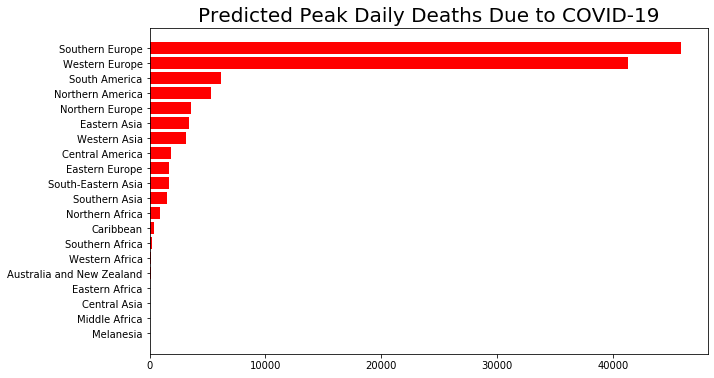

In [21]:
# pull data from doomsday
region = doomsday.select('Sub-Region').sort(asc('Deaths')).rdd.map(lambda x: x[0]).collect()
deaths = doomsday.select('Deaths').sort(asc('Deaths')).rdd.map(lambda x: x[0]).collect()

# plot
plt.figure(figsize=(10,6))
plt.barh(region, deaths, color='r')
plt.title('Predicted Peak Daily Deaths Due to COVID-19', fontsize=20)
plt.show()